<div style=" background-color: RGB(0,114,200);" >
<h1 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">PROJET 10 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; color:#fff; text-align: center">Détectez des faux billets avec R ou Python <br/><br/> Test des algorithmes</h2>
</div>

# Table des matières
* [Etape 1 - Importation des librairies, chargement des fichiers et définition de fonctions](#etape1)
    * [1.1 - Importation des librairies](#section1_1)
    * [1.2 - Graphiques](#section1_2)
    * [1.3 - Chargement des fichiers](#section1_3)
    * [1.4 - Définition de fonctions](#section1_4)
* [Etape 2 - Analyse et nettoyage des fichiers](#etape2)
    * [2.1 - Analyse exploratoire du dataset](#section2_1)
        * [2.1.1. Analyse](#section2_1_1)
        * [2.1.2. ACP](#section2_1_2)
    * [2.2 - Nettoyage](#section2_1)
        * [2.2.1. Test de la régression linéaire avec sélection des indicateurs](#section2_2_1)
* [Etape 3 - k-means](#etape3)
* [Etape 4 - Random forest](#etape4)
* [Etape 5 - Régression logistique](#etape5)
* [Etape 6 - k-Neighbors Classifier](#etape6)
* [Etape 7 - Comparaison](#etape7)

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape1"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies, chargement des fichiers et définition de fonctions</h2></a>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_1"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.1 - Importation des librairies</h3></a>
</div>

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white , normal_ad
from scipy import stats

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_2"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.2 - Graphiques</h3></a>
</div>

In [2]:
#On charge seaborn
sns.set()

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_3"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.3 - Chargement des données</h3></a>
</div>

In [3]:
#Chargement du fichier
dataset = pd.read_csv("billets.csv", sep=";")

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section1_4"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">1.4 - Définition de fonctions</h3></a>
</div>

In [4]:
#Graphes de corrélation
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape2"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse et nettoyage des fichiers</h2></a>
</div>

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section2_1"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.1 - Analyse exploratoire du dataset</h3></a>
</div>

<a class="anchor" id="section2_1_1"><h3 style="color: RGB(0,150,250); ">2.1.1. Analyse</h3></a>

In [5]:
#visualisation des premières lignes
dataset.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [6]:
#visualisation des dernières lignes
dataset.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


In [7]:
#dimensions du dataframe
dataset.shape
print('Le dataframe compte ',dataset.shape[0],' individus pour',dataset.shape[1],'variables.')

Le dataframe compte  1500  individus pour 7 variables.


In [8]:
#Indications sur les variables
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
#Calcul de la proportion de valeurs manquantes dans le dataset
dataset.isna().mean()

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

Quelques valeurs manquantes dans la variable margin_low.

In [10]:
#Y a-t-il des valeurs en double ?
print('Il y a',dataset.duplicated().sum(),'valeurs en double')

Il y a 0 valeurs en double


In [11]:
#Combien y a-t-il de valeurs différentes par colonne ?
dataset.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [12]:
#dispersion globale des données
dataset.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


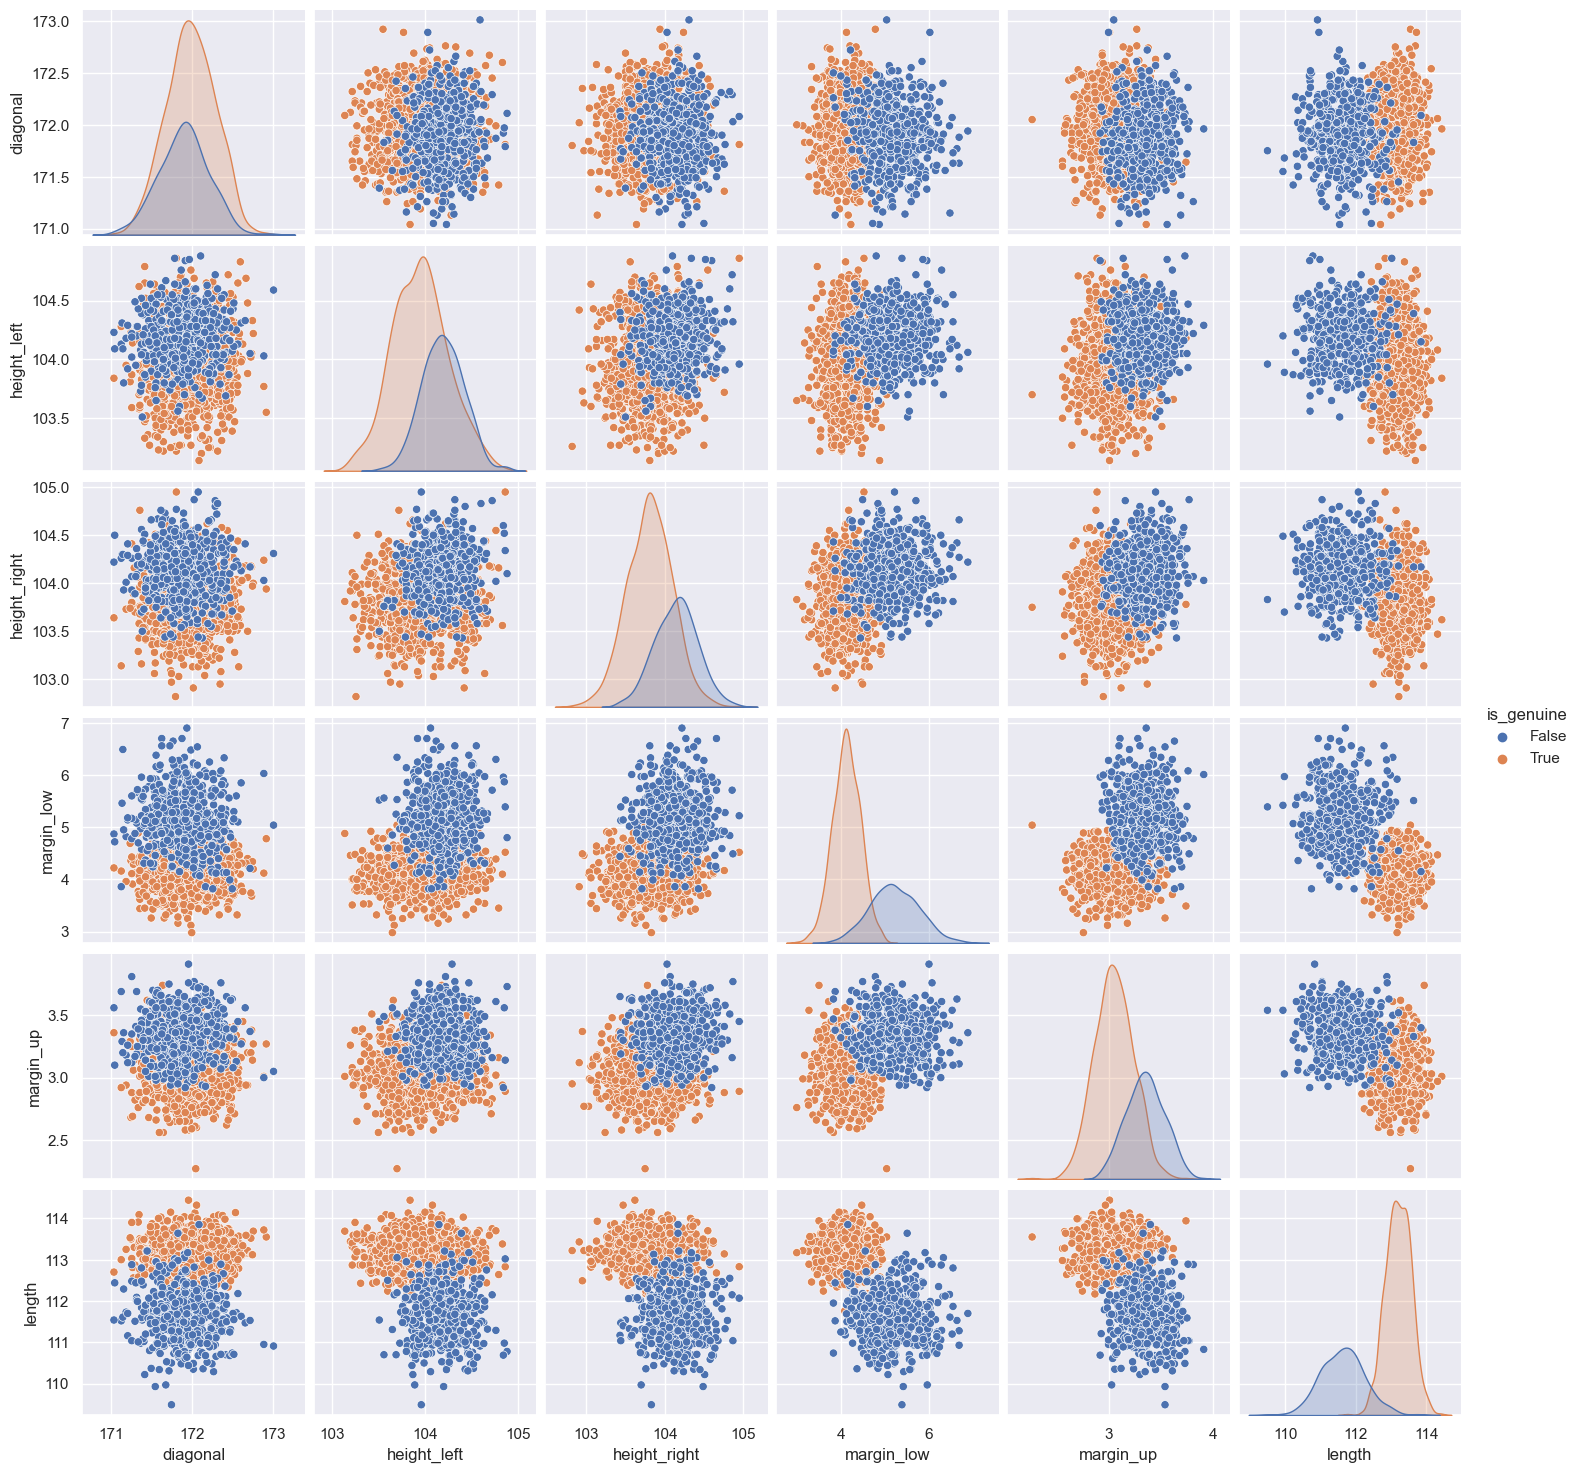

In [13]:
sns.pairplot(dataset, hue='is_genuine')

Il est difficile de formellement séparer les faux billets des vrais juste en comparant les caractéristiques deux à deux.
<br/>
On peut tout de même faire quelques observations :
<ul>
    <li>margin_low et length semblent mieux séparer les vrais billets des faux</li>
    </ul>

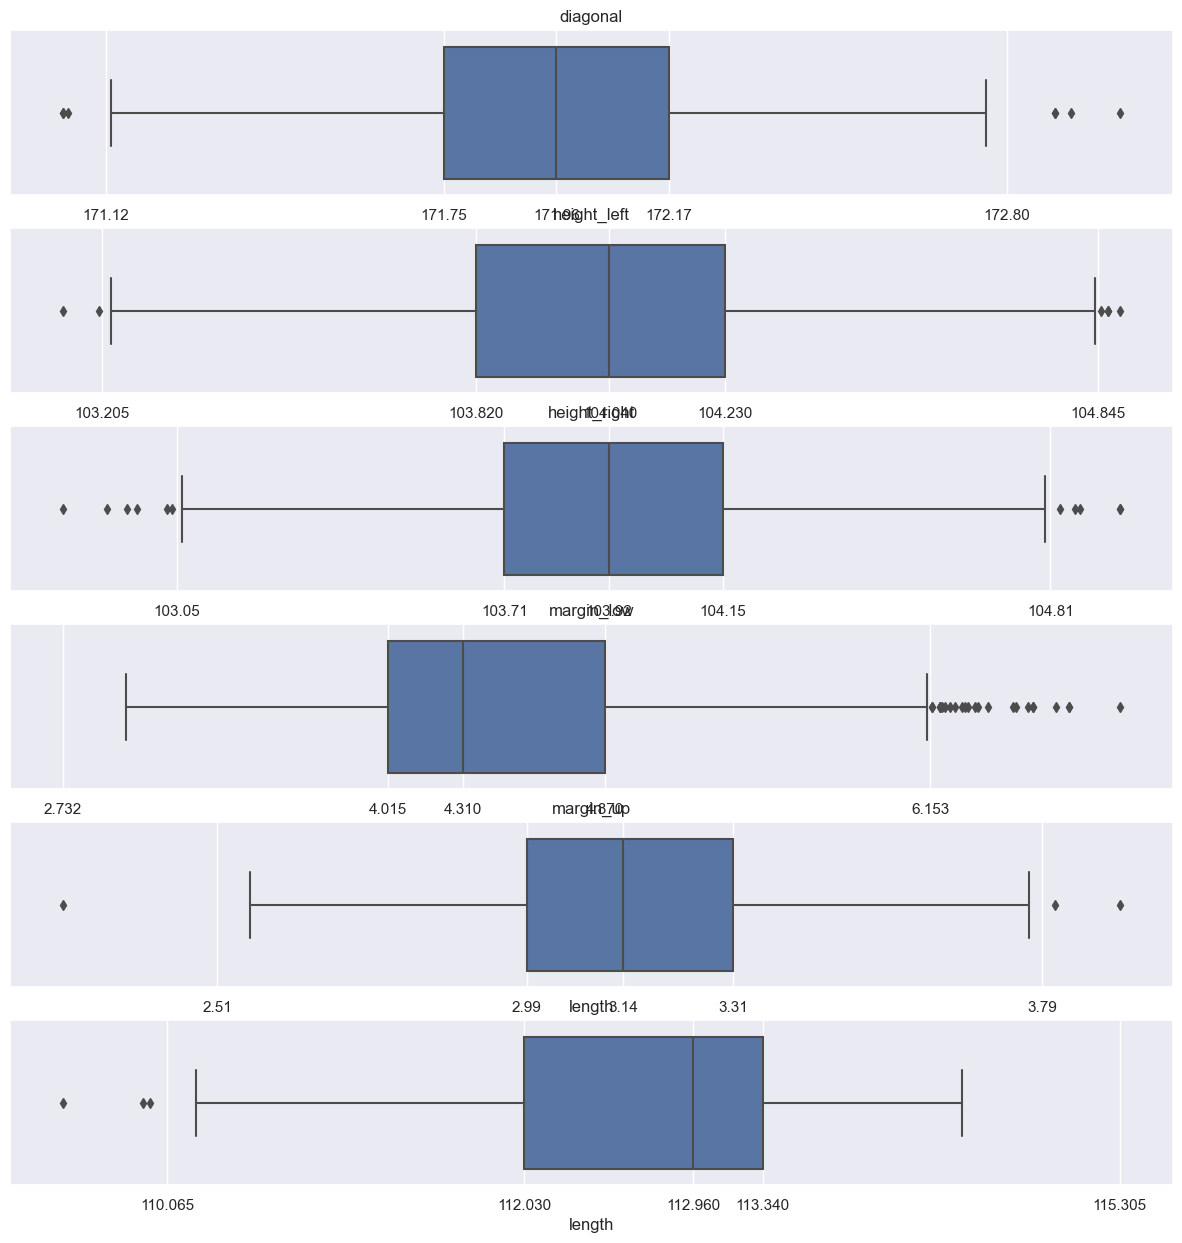

In [14]:
#Boxplot des variables
df=dataset.copy()

fig = plt.figure(figsize=(15, 15))
k=1
for modalite in df.columns.drop('is_genuine') :
    ax = fig.add_subplot(6,1, k)
    
    #Mise en évidence des outliers avec q1-1.5*iqr et q3+1.5*iqr
    quantiles = np.quantile(df.loc[~df[modalite].isna(),modalite], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
    q1=quantiles[1]
    q3=quantiles[3]
    iqr=q3-q1
    quantiles[0]=q1-1.5*iqr
    quantiles[-1]=q3+1.5*iqr
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size, color='b', ls=':', lw=0.5, zorder=0)
    ax.set_xticks(quantiles)
    
    
    sns.boxplot(data=df,x=modalite)
    plt.title(modalite)
    k+=1
    
plt.show()

Beaucoup d'outiers élevés sur margin_up

Question : est-ce que nos billets avec des valeurs manqauntes ont le reste de leurs variables en valeurs abérantes ?

In [15]:
dataset.loc[dataset['margin_low'].isna()].sort_values('height_right')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
251,True,171.80,103.26,102.82,NaN,2.95,113.22
445,True,172.34,104.42,103.22,NaN,3.01,112.97
919,True,171.92,103.68,103.45,NaN,2.58,113.68
72,True,171.94,103.89,103.45,NaN,3.25,112.79
611,True,171.80,103.68,103.49,NaN,3.30,112.84
413,True,172.30,103.66,103.50,NaN,3.16,112.95
410,True,172.56,103.72,103.51,NaN,3.12,112.95
945,True,172.09,103.74,103.52,NaN,3.02,112.78
654,True,171.97,103.69,103.54,NaN,2.70,112.79
798,True,171.96,103.84,103.62,NaN,3.01,114.44


La seule valeur abérante trouvée est le height_right du billet d'index 251 dont la valeur est considérée comme annormalement basse. je la supprime du dataset.

In [16]:
dataset=dataset.loc[~dataset.index.isin([251])]

Zscores

In [17]:
# visualisation des outliers avec les z-scores

#Création d'une liste z_modalites
z_modalites=[]
for modalite in df.columns:
    df[('z_',modalite)] = stats.zscore(df[modalite])
    z_modalites.append(('z_',modalite))

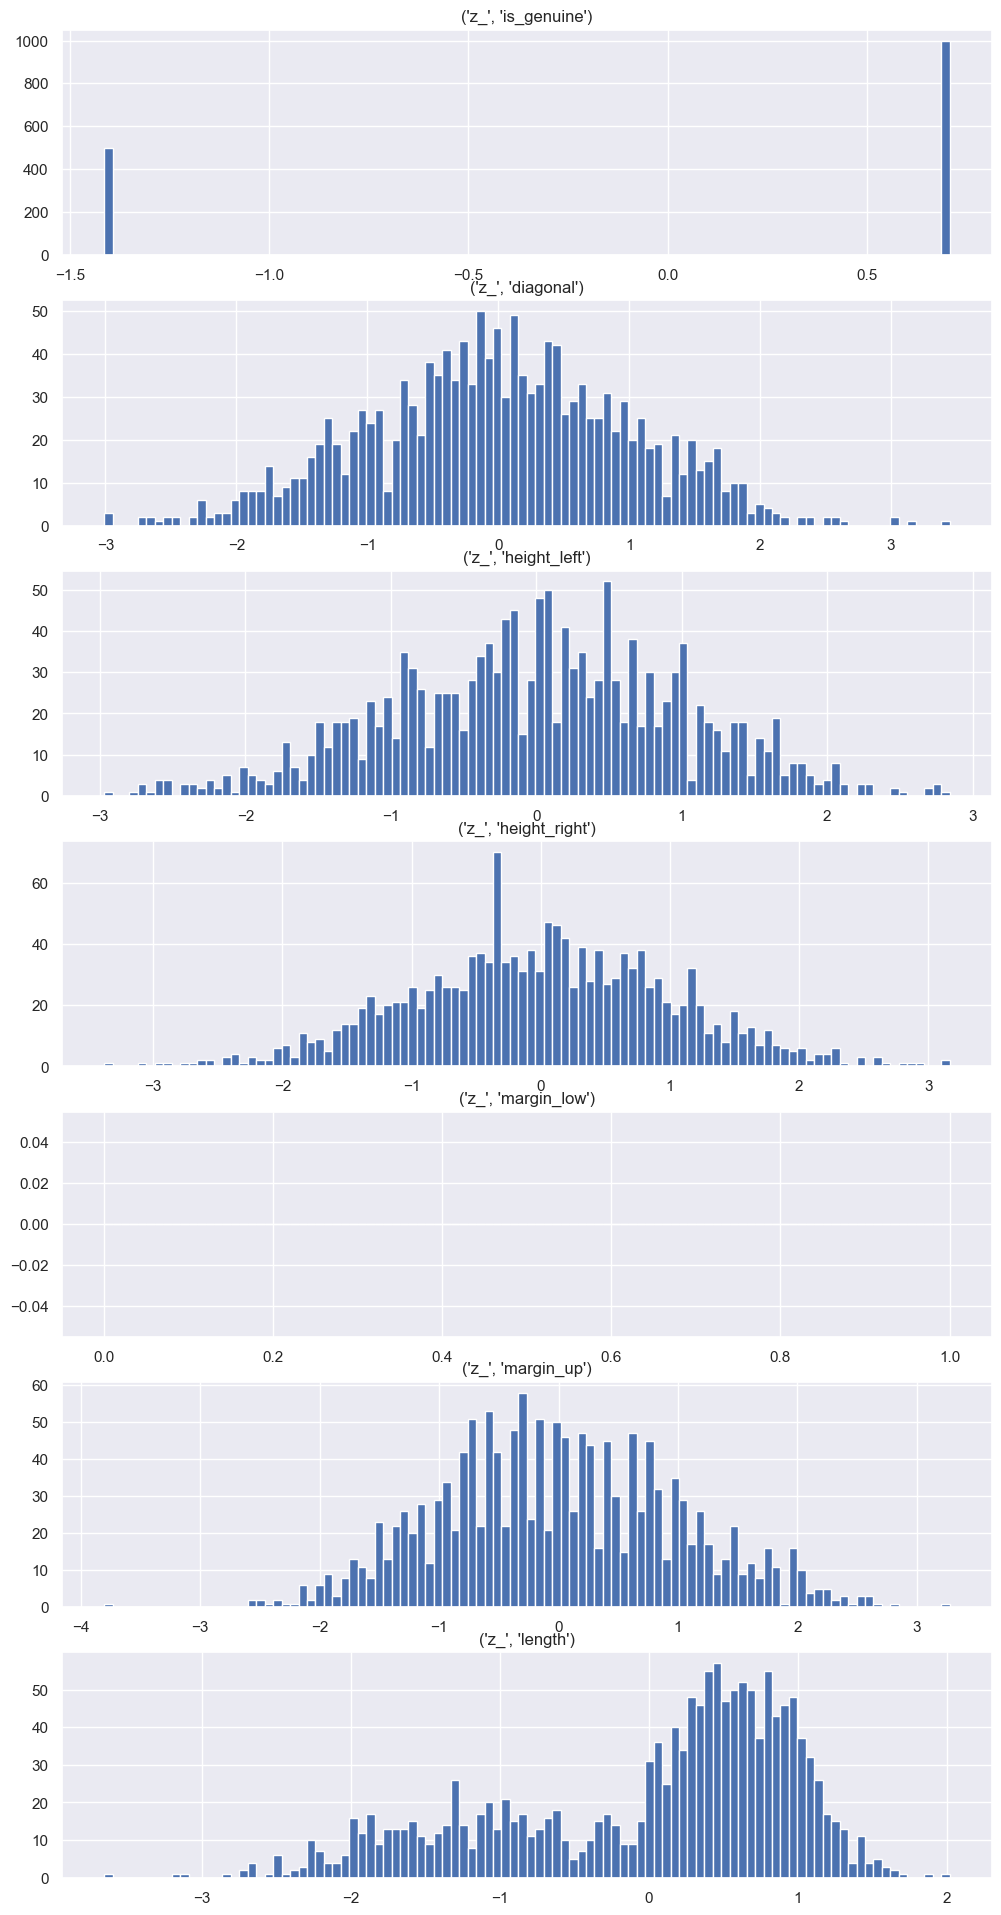

In [18]:
fig = plt.figure(figsize=(12, 24))

k=1
for modalite in z_modalites :
    ax = fig.add_subplot(7,1, k)
    k+=1
    df[modalite].hist(bins = 100)
    ax.grid(True, which = 'both')
    ax.set_title(modalite)

plt.show()

On observe bien des gaussiennes, sauf pour 'length' où on a des outliers petits.

<a class="anchor" id="section2_1_2"><h3 style="color: RGB(0,150,250); ">2.1.2. ACP</h3></a>

Réalisation d'une ACP pour trouver des liens entre les variables.

In [19]:
#Suppression des valeurs manquantes le temps de faire l'ACP
dataset_ACP=dataset.copy()
dataset_ACP=dataset_ACP.loc[~dataset_ACP['margin_low'].isna(),:]

In [20]:
#split du dataset
X = dataset_ACP.values
#récupération des noms des variables
features = dataset_ACP.columns

Commençons par scaler les données. On instancie :

In [21]:
scaler = StandardScaler()

On fit et transforme :

In [22]:
X_scaled = scaler.fit_transform(X)

Vérifions si nous avons bien une moyenne à 0 et un écart type à 1 :

In [23]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6
mean,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [24]:
n_components = 7
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=7)

Elaboration du scree plot

In [25]:
explained_variance=pca.explained_variance_ratio_
print(explained_variance)
print('Ici la 1ère composante capte',round(explained_variance[0]*100,2),'% des données initiales, la deuxième',round(explained_variance[1]*100,2),'%,ect ...')

[0.4916298  0.14582988 0.11361004 0.10206929 0.0845501  0.0466567
 0.0156542 ]
Ici la 1ère composante capte 49.16 % des données initiales, la deuxième 14.58 %,ect ...


In [26]:
#enregistrement dans la variable scree
scree = (pca.explained_variance_ratio_*100).round(2)
#Calcul de la somme cumulée
scree_cum = scree.cumsum().round()
#définition d'une variable avec la liste des composantes
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7]

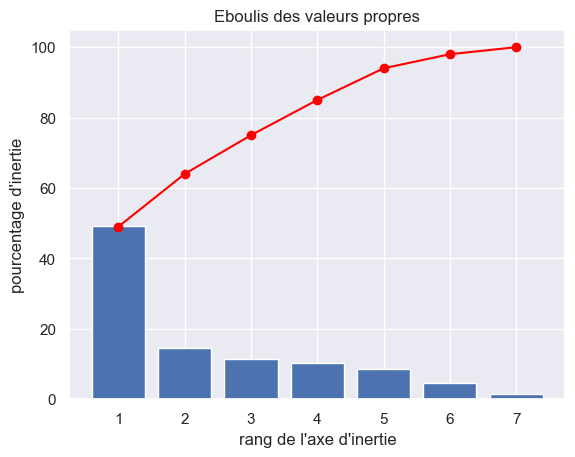

In [27]:
#affichage de l'éboulis des valeurs propres
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

La méthode du coude suggère l'utilisation de 5 composantes.

<Axes: >

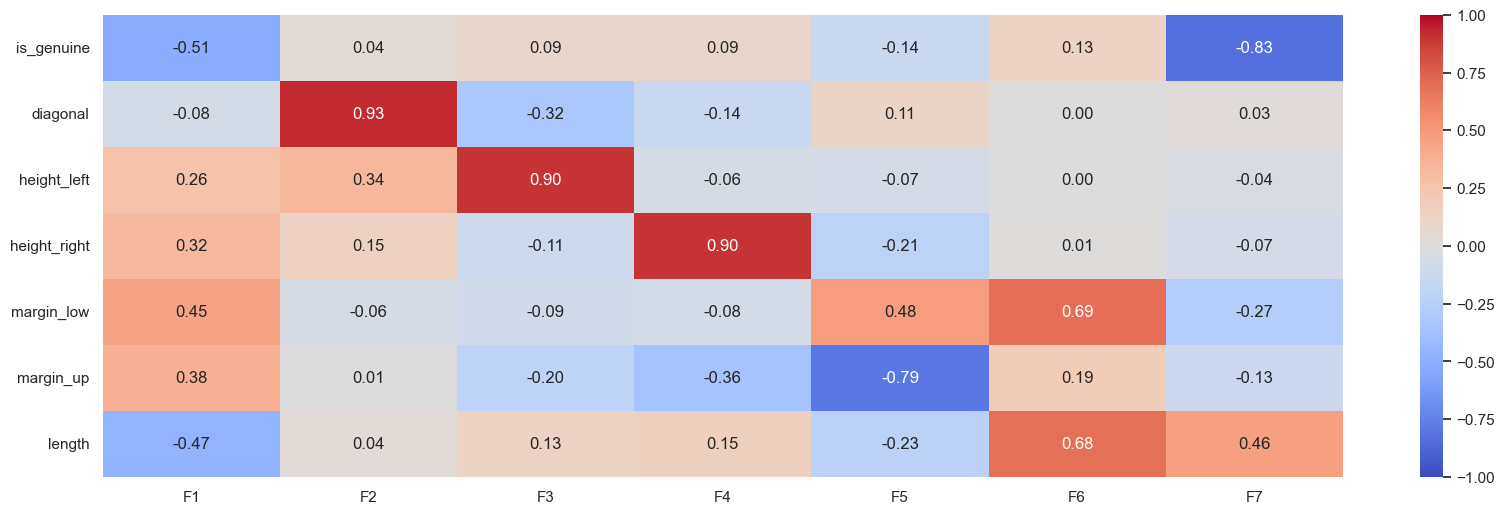

In [28]:
#Calcul des composantes
pcs = pd.DataFrame(pca.components_)
#Renommage des noms des composantes et des features
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
#Affichage de la heatmap
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

Graphes de corrélation deux à deux jusqu'à F6

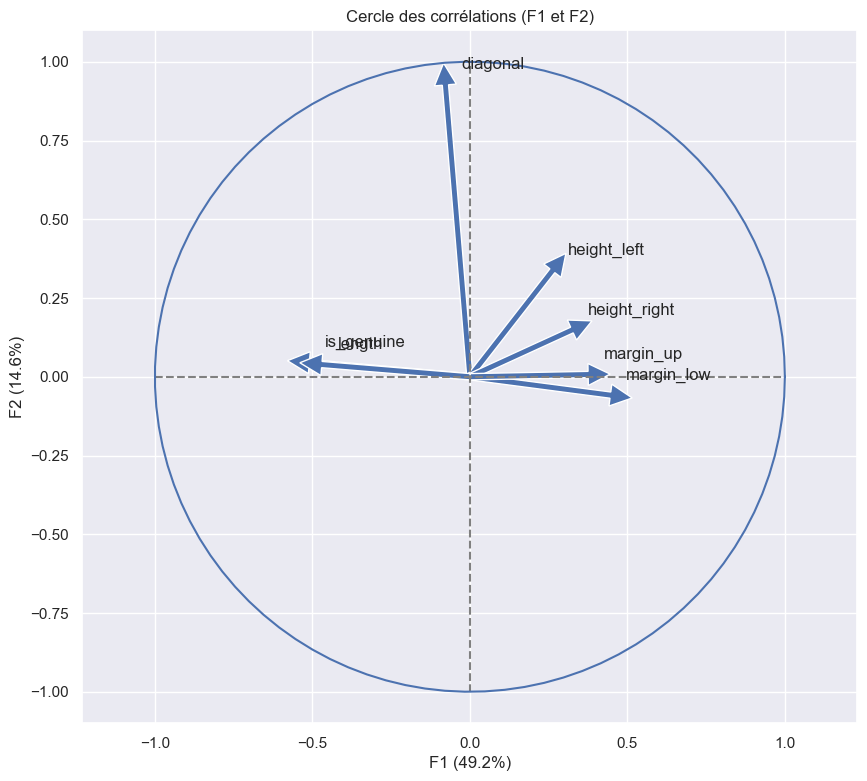

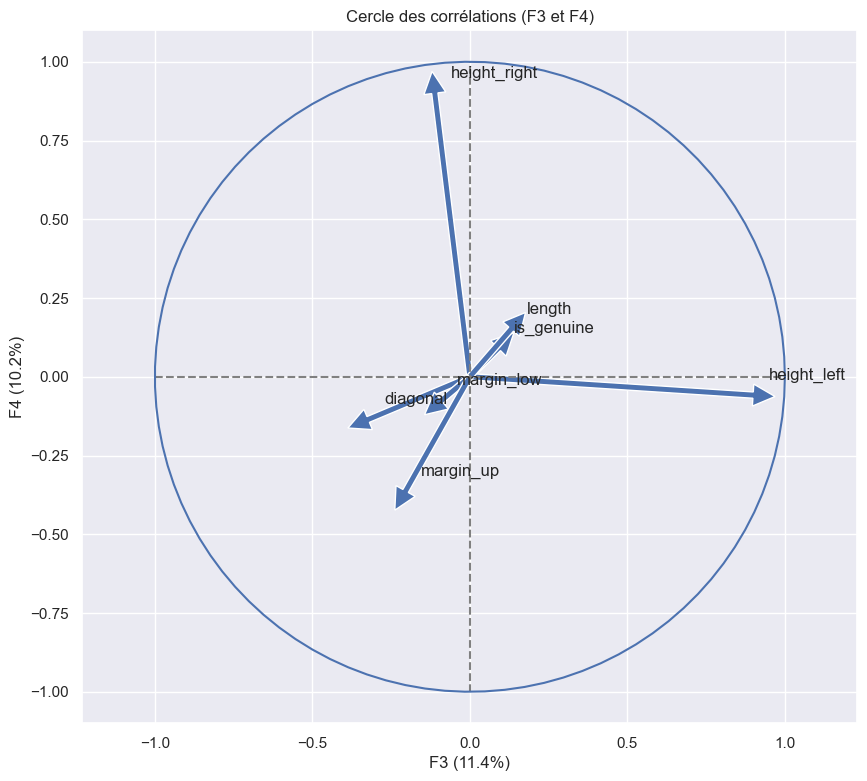

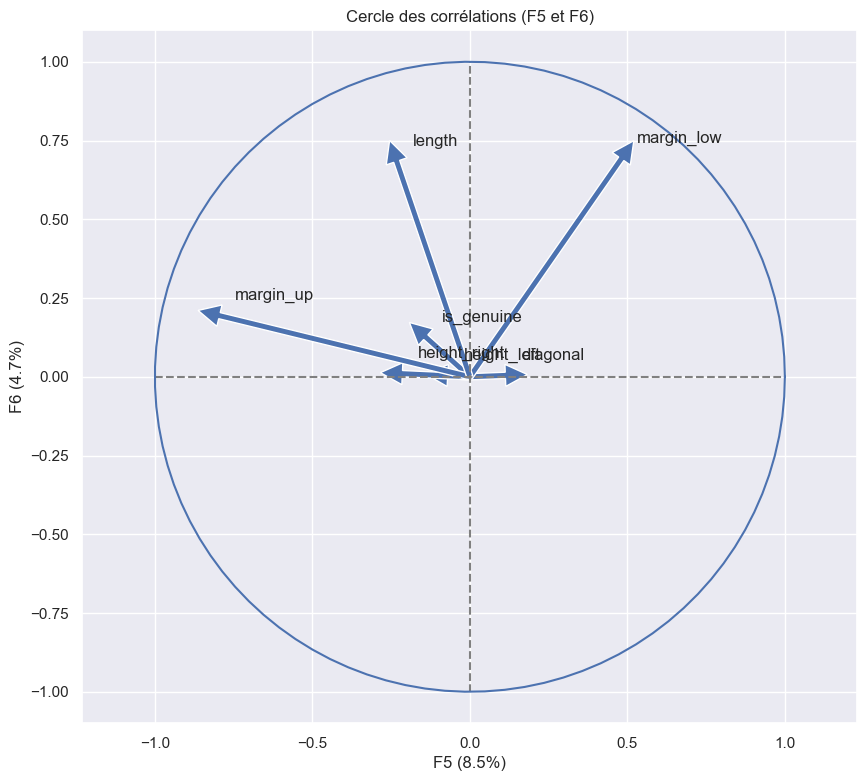

In [29]:
i=0
while i<n_components-2:
    x_y=i,i+1
    correlation_graph(pca,x_y,features)
    i+=2

Graphe 1 :
<ul>F1 :
    <li>corrélations positives pour margin_up et margin_low</li>
    <li>corrélations négatives pour length et is_genuine</li>
F2 :
    <li>corrélation positive pour diagonal</li>
</ul>
Graphe 2 :
<ul>F3 :
    <li>corrélation positive height_left</li>
F4 :
    <li>corrélation positive height_right</li>
</ul>
Graphe 3 :
<ul>F5 :
    <li>corrélation négative pour margin_up</li>
F6 :
    <li>corrélations positives pour margin_low et height</li>
</ul>

Conclusion :

Peu de valeurs synthétiques sont représentatives de plusieurs variables. On peut cependant faire le lien entre les marges, la longueur et l'authenticité du billet grâce à à F1.

C'est pourquoi j'utiliserais margin_up, length et is_genuine pour remplir les margin_low manquants.

<div style="border: 1px solid RGB(0,150,250);" >
<a class="anchor" id="section2_2"><h3 style="margin: auto; padding: 20px; color: RGB(0,150,250); ">2.2 - Nettoyage</h3></a>
</div>

<a class="anchor" id="section2_2_1"><h3 style="color: RGB(0,150,250); ">2.2.1. Test de la validité de la régression linéaire</h3></a>

In [30]:
#Reprise du dataset sans les valeurs manquantes
dataset_lineaire=dataset_ACP.copy()

#split du dataset
X = dataset_lineaire.drop(['margin_low','is_genuine'], axis=1)
X = sm.add_constant(X)
y = dataset_lineaire['margin_low']

#OLS = moindres carrés
model = sm.OLS(y, X)
results = model.fit()

#Test de Breusch-Pagan pour l'homoscédasticité
_,p_value, _, _=het_breuschpagan(results.resid,results.model.exog)
#conversion du test en chaine de caractère
pb_result=f"\nBreusch-Pagan test :\n"
pb_result+=f" - p-valeur:{p_value}\n"

print(results.summary())
print(pb_result)

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Wed, 27 Dec 2023   Prob (F-statistic):          2.60e-202
Time:                        17:36:08   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.9948      9.656      2.382   

Le R² est globalement satisfaisant mais ne suffit pas à juger si la régression est bonne.

<strong>Normalité des résidus :</strong>
prob(Omnibus) et prob(JB) en défaveur de la normalité des résidus.  On effectue un test d'Aderson-Darling qui nous indique que les résidus suivent finalement une distribution Normale.

La p-valeur du test d'Aderson-Darling vaut 5.114137678791534e-12


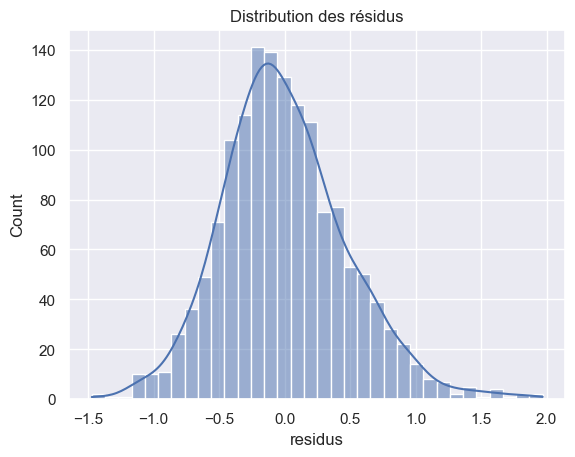

In [31]:
# Normalité des résidus
# Creation d'une colonne contenant les residus:
dataset_lineaire['margin_low_pred'] = results.predict(X)
dataset_lineaire['residus'] = dataset_lineaire['margin_low'] - dataset_lineaire['margin_low_pred']

# Normalite:
print("La p-valeur du test d'Aderson-Darling vaut", normal_ad(dataset_lineaire['residus'])[1])

# Graphique:
sns.histplot(dataset_lineaire['residus'], kde=True)
plt.title('Distribution des résidus')
plt.show()

La p-veleur <<0.05, les résidus suivent finalementune loie normale.

<strong>Indépendance des résidus :</strong>
Durbin-Watson proche de 2 ; la condition est satisfaite.

<strong>Variance des résidus (Homocédasticité) :</strong>
Le test de Breusch-Pagan ne fonctionne pas très bien pour les distributions non-normales et non-linéaires. Faisons un test de White qui est en fait un cas particulier du Breusch-Pagan.

{'Test Statistique': 109.86015196864321, 'p-valeur': 2.0828244989957973e-14, 'F-Statistic': 5.8537312078002, 'F-Test p-value': 4.974865092745863e-15}


Text(0.5, 1.0, 'Homoscédasticité')

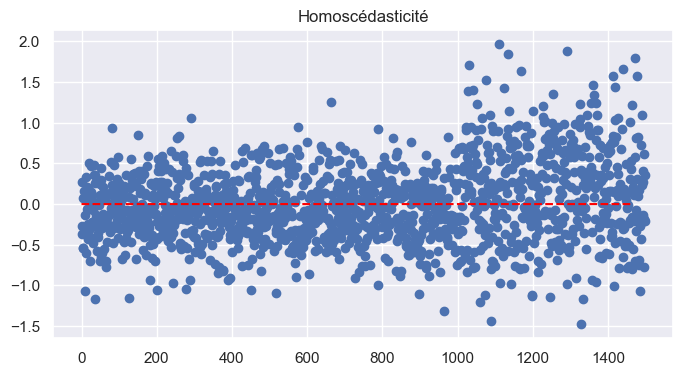

In [32]:
#Variance des résidus:
white_result = het_white(results.resid, results.model.exog)
labels_white_result = ["Test Statistique", "p-valeur", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels_white_result, white_result)))

#Graphique:
plt.subplots(figsize=(8, 4))
plt.scatter(x=dataset_lineaire.index, y=dataset_lineaire['residus'])
plt.plot(np.repeat(0, len(dataset_lineaire.index)+2), color='red', linestyle='--')
plt.title('Homoscédasticité')

L'hypothèse d'homoscédasticité de la régression linéaire est donc considérée comme vérifiée au risque alpha 5 %

<strong>Imputation des valeurs manquantes</strong>

In [33]:
#Création d'un dataset ne contenant que les billets avec des valeurs manquantes
manquants=dataset.loc[dataset['margin_low'].isna(),:].copy()

#Prédiction
predictions=results.predict(sm.add_constant(manquants.drop(columns=['margin_low','is_genuine'])))

#Ajout des prédictions
manquants['margin_low']=predictions

manquants

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.318525,3.25,112.79
99,True,171.93,104.07,104.18,4.393668,3.14,113.08
151,True,172.07,103.80,104.38,4.410457,3.02,112.93
197,True,171.45,103.66,103.80,4.319014,3.62,113.27
241,True,171.83,104.14,104.06,4.650617,3.02,112.36
284,True,171.92,103.83,103.76,4.179736,3.23,113.29
334,True,171.85,103.70,103.96,4.127442,3.00,113.36
410,True,172.56,103.72,103.51,4.135034,3.12,112.95
413,True,172.30,103.66,103.50,4.160539,3.16,112.95
445,True,172.34,104.42,103.22,4.177420,3.01,112.97


In [34]:
#Ajout des billets au dataset final
data=dataset_ACP.append(manquants)

#Ecriture dans un fichier pour l'entrainement du code final
data.to_csv('dataset_nettoye.csv')

C:\Users\adrie\AppData\Local\Temp\ipykernel_17344\1023416284.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data=dataset_ACP.append(manquants)


In [35]:
#Vérifiction de l'ajout des billets
print(data.shape)
data.tail(10)

(1499, 7)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
946,True,171.63,103.87,104.66,4.710533,3.27,112.68
981,True,172.02,104.23,103.72,4.137780,2.99,113.37
1076,False,171.57,104.27,104.44,5.050277,3.21,111.87
1121,False,171.40,104.38,104.19,4.802145,3.17,112.39
1176,False,171.59,104.05,103.94,5.067584,3.02,111.29
1303,False,172.17,104.49,103.76,5.047570,2.93,111.21
1315,False,172.08,104.15,104.17,4.778967,3.40,112.29
1347,False,171.72,104.46,104.12,5.726993,3.61,110.31
1435,False,172.66,104.33,104.41,5.185862,3.56,111.47
1438,False,171.90,104.28,104.29,5.140043,3.24,111.49


<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape3"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - k-means</h2></a>
</div>

In [36]:
#création d'une copie de data pour le k-means
data_kmeans=data[['diagonal','height_left','height_right','margin_low','margin_up','length']].copy()

In [37]:
#split du dataset
X = data_kmeans.values
#récupération des noms des variables
features = data_kmeans.columns
#Définition de la colonne cible
y = data.is_genuine

Méthode du coude

In [38]:
#On défini d'abord une liste vide pour sotcker nos inerties:
intertia = []
#On défini ensuite la liste du nombre de clusters que l'on veut tester:
k_list = range(1, 6)
#Ensuite, pour chaque valeur de k, on entraine un k-means spécifique et on stocke son inertie :
for i in k_list :
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(X)
  intertia.append(kmeans.inertia_)

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

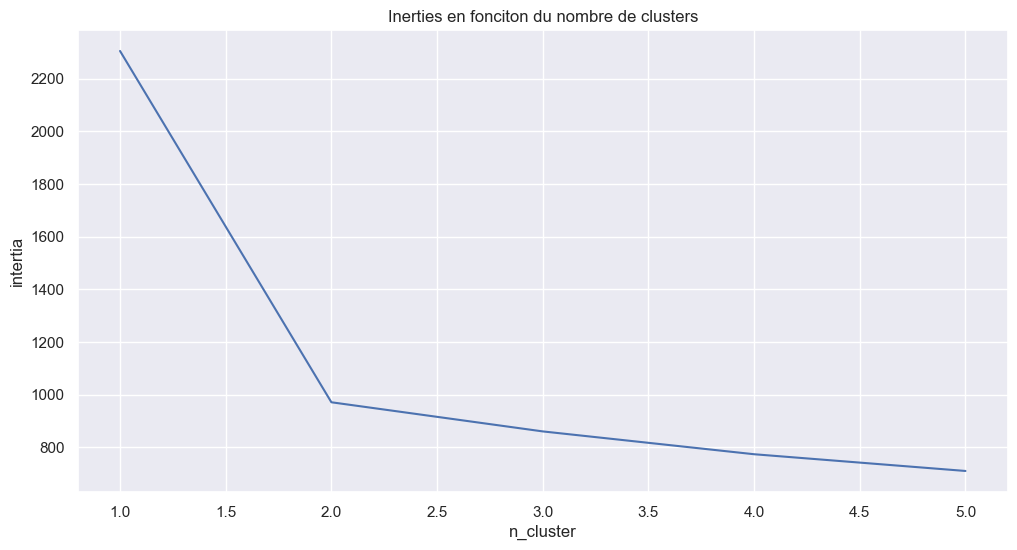

In [39]:
#Affichage du résultat
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")
ax.set_title("Inerties en fonciton du nombre de clusters")
ax = plt.plot(k_list, intertia)

La méthode du coude suggère deux clusters. On espère que cela va correspondre à l'authenticité des billets.

In [40]:
n_clusters=2
#Nous devons d'abord ré-entrainer un estimateur:
kmeans = KMeans(n_clusters)
kmeans.fit(X)

#Les clusters sont mis dans la variable labels
labels=kmeans.labels_.copy()

#Ajout des labels à data
data_kmeans['cluster_k_means'] = labels

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


In [41]:
# Voici les scores de classification
print("score", kmeans.score(X))
print("silhouette_score: ", silhouette_score(X,kmeans.labels_ ))

score -970.4984847369041
silhouette_score:  0.5141292657641929


Le coefficient de silhouette est de 0.55 environ, ce qui est plutôt satisfaisant.

In [42]:
#Match categories de kmeans avec les bonnes categories du dataset

data_kmeans['is_genuine']=data['is_genuine']

#si jamais les numéros de clusters ne correspondent pas avec is_genuine
if int(data_kmeans.iloc[0,-2])!=data_kmeans.iloc[0,-1]:
    # temp values
    labels[labels==0] = 5
    labels[labels==1] = 10
    # Bonnes catégories
    labels[labels == 5] = 1
    labels[labels == 10] = 0
    data_kmeans['cluster_k_means'] = labels

print("confusion_matrix\n",confusion_matrix(y,labels ))
print(confusion_matrix(y,labels )[0,1],'faux positifs et ',confusion_matrix(y,labels )[1,0],'faux négatifs')

confusion_matrix
 [[481  19]
 [  3 996]]
19 faux positifs et  3 faux négatifs


In [43]:
print("accuracy_score",accuracy_score(y,labels ))

accuracy_score 0.9853235490326885


In [44]:
#F1 score
f1_score(y,labels)

0.9890764647467725

In [45]:
data_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster_k_means,is_genuine
0,171.81,104.86,104.95,4.520000,2.89,112.83,1,True
1,171.46,103.36,103.66,3.770000,2.99,113.09,1,True
2,172.69,104.48,103.50,4.400000,2.94,113.16,1,True
3,171.36,103.91,103.94,3.620000,3.01,113.51,1,True
4,171.73,104.28,103.46,4.040000,3.48,112.54,1,True
...,...,...,...,...,...,...,...,...
1303,172.17,104.49,103.76,5.047570,2.93,111.21,0,False
1315,172.08,104.15,104.17,4.778967,3.40,112.29,0,False
1347,171.72,104.46,104.12,5.726993,3.61,110.31,0,False
1435,172.66,104.33,104.41,5.185862,3.56,111.47,0,False


<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape4"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Random forest</h2></a>
</div>

In [46]:
#création d'une copie de data pour le random forest
data_forest=data[['diagonal','height_left','height_right','margin_low','margin_up','length']].copy()
#split du dataset
X = data_forest.values
#récupération des noms des variables
features = ['diagonal','height_left','height_right','margin_low','margin_up','length']
#Définition de la colonne cible
y = data.is_genuine.values

In [47]:
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.8, random_state=8)

In [48]:
X.shape

(1499, 6)

In [49]:
#Test d'acuracy du random forest sans contrainte de profondeur
tree_counts = [1,2,3,4,5,10,15,20,25,30,40,50, 60, 70, 80, 90, 100, 110, 120, 150]

accuracy  = []

for n_estimator in tree_counts:
    clf = RandomForestClassifier(
        n_estimators = n_estimator,
        max_depth = None,
        max_features = None,
        random_state = 8
        )

    clf.fit(X_train, y_train)
    accuracy.append({
        'n': n_estimator,
        'test': clf.score(X_test, y_test),
        'train': clf.score(X_train, y_train),
    })

    print(f"{n_estimator} trees \t accuracy test: {np.round(clf.score(X_test, y_test), 3)} \t accuracy train {np.round(clf.score(X_train, y_train), 3)}", )


accuracy = pd.DataFrame(accuracy)
accuracy['delta'] = np.abs(accuracy.train - accuracy.test)

1 trees 	 accuracy test: 0.987 	 accuracy train 0.994
2 trees 	 accuracy test: 0.983 	 accuracy train 0.993
3 trees 	 accuracy test: 0.987 	 accuracy train 0.997
4 trees 	 accuracy test: 0.987 	 accuracy train 0.997
5 trees 	 accuracy test: 0.993 	 accuracy train 0.998
10 trees 	 accuracy test: 0.993 	 accuracy train 0.999
15 trees 	 accuracy test: 0.997 	 accuracy train 0.999
20 trees 	 accuracy test: 0.993 	 accuracy train 1.0
25 trees 	 accuracy test: 0.993 	 accuracy train 1.0
30 trees 	 accuracy test: 0.993 	 accuracy train 1.0
40 trees 	 accuracy test: 0.993 	 accuracy train 1.0
50 trees 	 accuracy test: 0.99 	 accuracy train 1.0
60 trees 	 accuracy test: 0.99 	 accuracy train 1.0
70 trees 	 accuracy test: 0.99 	 accuracy train 1.0
80 trees 	 accuracy test: 0.99 	 accuracy train 1.0
90 trees 	 accuracy test: 0.99 	 accuracy train 1.0
100 trees 	 accuracy test: 0.99 	 accuracy train 1.0
110 trees 	 accuracy test: 0.993 	 accuracy train 1.0
120 trees 	 accuracy test: 0.993 	 accura

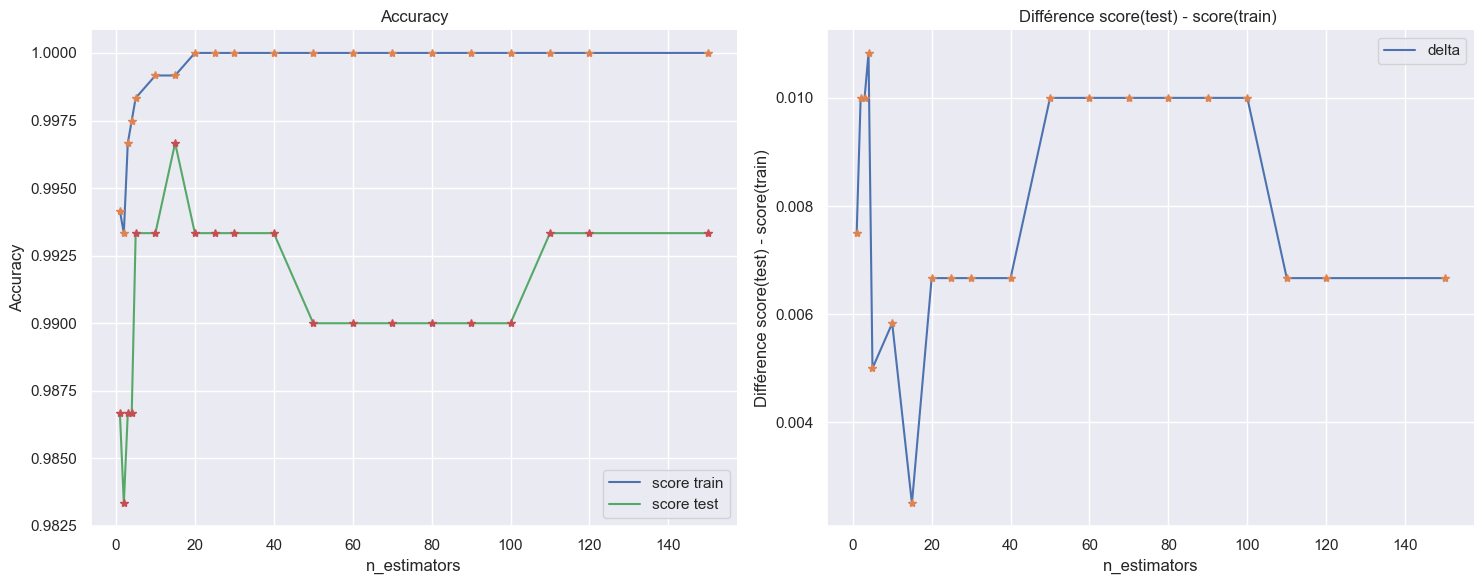

In [50]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)
plt.plot(accuracy.n, accuracy.train, label = 'score train')
plt.plot(accuracy.n, accuracy.train,'*')

plt.plot(accuracy.n, accuracy.test, label = 'score test')
plt.plot(accuracy.n, accuracy.test,'*')

# plt.plot(accuracy.n, accuracy.delta, label = 'delta')
# plt.plot(accuracy.n, accuracy.delta,'*')

ax.grid(True, which = 'both')
ax.set_title('Accuracy')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(0.9 * np.min(accuracy), 1.1 * np.max(accuracy))

ax.legend()
# --
ax = fig.add_subplot(1, 2, 2)
plt.plot(accuracy.n, accuracy.delta, label = 'delta')
plt.plot(accuracy.n, accuracy.delta,'*')

ax.grid(True, which = 'both')
ax.set_title('Différence score(test) - score(train) ')
ax.set_xlabel('n_estimators')
ax.set_ylabel('Différence score(test) - score(train)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_ylim(0.9 * np.min(accuracy), 1.1 * np.max(accuracy))

ax.legend()
plt.tight_layout()

On utilise donc 30 arbres dans la random forest.

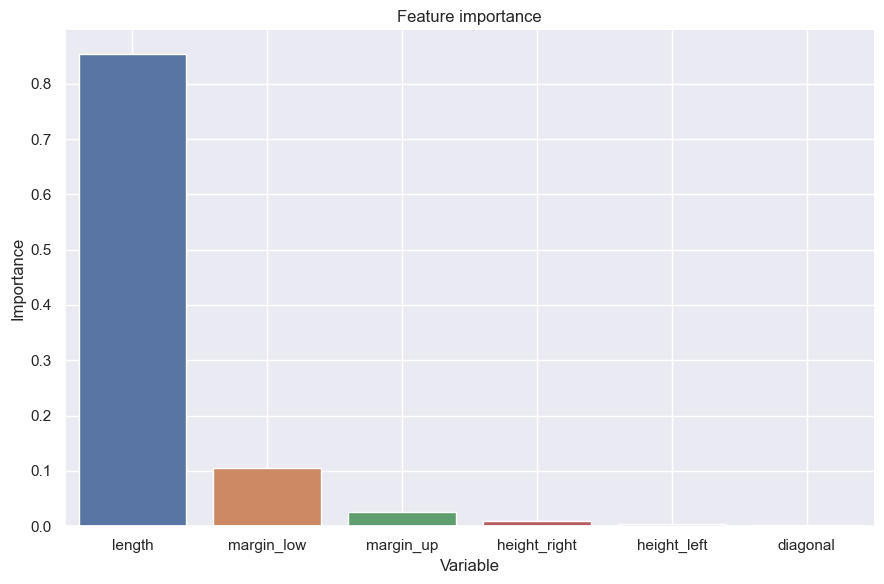

In [51]:
#importance des features

df = pd.DataFrame()
df['feature'] = features
df['importance'] = clf.feature_importances_
df.sort_values(by = 'importance', ascending = False, inplace = True)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(1, 1, 1)

sns.barplot(data = df, x='feature', y='importance')
ax.set_title('Feature importance')
ax.set_xlabel('Variable')
ax.set_ylabel('Importance')
ax.grid(True, which = 'both')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

In [52]:
#Création d'un dataframe prediction_forest qui contiendra le dataset test
prediction_forest=pd.DataFrame(X_test)
prediction_forest.columns=features

#Mise en oeuvre du random forest
clf = RandomForestClassifier(
        n_estimators = 30,
        max_depth = None,
        max_features = None,
        random_state = 8
        )
clf.fit(X_train, y_train)

#incorporation des prédictions dans le dataset
prediction_forest['prediction_forets']=clf.predict(X_test)

In [53]:
prediction_forest['is_genuine']=y_test

In [54]:
prediction_forest

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_forets,is_genuine
0,171.95,103.62,103.91,4.91,2.90,113.17,True,True
1,172.01,103.93,103.69,3.89,3.34,113.16,True,True
2,172.03,103.59,104.09,4.49,2.85,113.44,True,True
3,171.99,103.54,103.44,3.80,3.08,113.04,True,True
4,172.17,103.61,104.33,3.39,2.82,112.79,True,True
...,...,...,...,...,...,...,...,...
295,171.99,103.97,103.89,4.22,3.17,113.12,True,True
296,171.86,104.12,104.10,6.01,3.34,111.91,False,False
297,171.73,104.17,104.02,3.64,2.64,112.72,True,True
298,171.70,104.42,104.04,4.75,3.32,111.63,False,False


In [55]:
print("confusion_matrix\n",confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] ))
print(confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] )[0,1],'faux positifs et ',confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] )[1,0],'faux négatifs')

confusion_matrix
 [[ 92   1]
 [  1 206]]
1 faux positifs et  1 faux négatifs


In [56]:
f1_score(y_test, prediction_forest['prediction_forets'])

0.9951690821256038

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape5"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 5 - Régression logistique</h2></a>
</div>

In [57]:
#création d'une copie de data pour la régression logistique
data_logistique=data[['diagonal','height_left','height_right','margin_low','margin_up','length']].copy()
#split du dataset
X = data_logistique.values
#récupération des noms des variables
features = ['diagonal','height_left','height_right','margin_low','margin_up','length']
#Définition de la colonne cible
y = data.is_genuine.values

In [58]:
# split train, test
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.8, random_state=8)

# initialisation et entraînement
clf = LogisticRegression(random_state=8).fit(X_train, y_train)

#Création d'un dataframe prediction_logistique qui contiendra le dataset test
prediction_logistique=pd.DataFrame(X_test)
prediction_logistique.columns=features

#incorporation des prédictions dans le dataset
prediction_logistique['prediction_logistique']=clf.predict(X_test)

In [59]:
prediction_logistique['is_genuine']=y_test

In [60]:
prediction_logistique

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_logistique,is_genuine
0,171.95,103.62,103.91,4.91,2.90,113.17,True,True
1,172.01,103.93,103.69,3.89,3.34,113.16,True,True
2,172.03,103.59,104.09,4.49,2.85,113.44,True,True
3,171.99,103.54,103.44,3.80,3.08,113.04,True,True
4,172.17,103.61,104.33,3.39,2.82,112.79,True,True
...,...,...,...,...,...,...,...,...
295,171.99,103.97,103.89,4.22,3.17,113.12,True,True
296,171.86,104.12,104.10,6.01,3.34,111.91,False,False
297,171.73,104.17,104.02,3.64,2.64,112.72,True,True
298,171.70,104.42,104.04,4.75,3.32,111.63,False,False


In [61]:
print("confusion_matrix\n",confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] ))
print(confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] )[0,1],'faux positifs et ',confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] )[1,0],'faux négatifs')

confusion_matrix
 [[ 92   1]
 [  1 206]]
1 faux positifs et  1 faux négatifs


In [62]:
f1_score(y_test, prediction_logistique['prediction_logistique'])

0.9951690821256038

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape6"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 6 - k-Neighbors Classifier</h2></a>
</div>

In [63]:
#création d'une copie de data pour le k-Neighbors Classifier
data_kNN=data[['diagonal','height_left','height_right','margin_low','margin_up','length']].copy()
#split du dataset
X = data_kNN.values
#récupération des noms des variables
features = ['diagonal','height_left','height_right','margin_low','margin_up','length']
#Définition de la colonne cible
y = data.is_genuine.values

In [64]:
# split train, test
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.8, random_state=8)

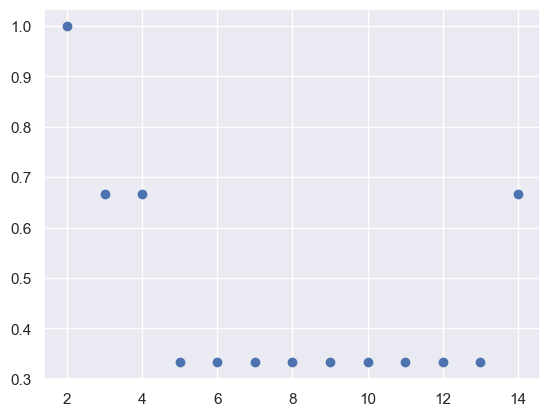

In [65]:
#Combien faut-il de voisins ?
errors=[]
for k in range(2,15):
    knn=neighbors.KNeighborsClassifier(k)
    errors.append(100*(1-knn.fit(X_train,y_train).score(X_test,y_test)))
plt.plot(range(2,15),errors,'o')
plt.show()

L'erreur est minimale à partir de 5 voisins.

In [66]:
# initialisation et entraînement
clf = neighbors.KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

#Création d'un dataframe prediction_logistique qui contiendra le dataset test
prediction_kNN=pd.DataFrame(X_test)
prediction_kNN.columns=features

#incorporation des prédictions dans le dataset
prediction_kNN['prediction_k-NN']=clf.predict(X_test)

#Incormoration des vraies données
prediction_kNN['is_genuine']=y_test

prediction_kNN

,diagonal,height_left,height_right,margin_low,margin_up,length,prediction_k-NN,is_genuine
0,171.95,103.62,103.91,4.91,2.90,113.17,True,True
1,172.01,103.93,103.69,3.89,3.34,113.16,True,True
2,172.03,103.59,104.09,4.49,2.85,113.44,True,True
3,171.99,103.54,103.44,3.80,3.08,113.04,True,True
4,172.17,103.61,104.33,3.39,2.82,112.79,True,True
...,...,...,...,...,...,...,...,...
295,171.99,103.97,103.89,4.22,3.17,113.12,True,True
296,171.86,104.12,104.10,6.01,3.34,111.91,False,False
297,171.73,104.17,104.02,3.64,2.64,112.72,True,True
298,171.70,104.42,104.04,4.75,3.32,111.63,False,False


In [67]:
print("confusion_matrix\n",confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] ))
print(confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] )[0,1],'faux positifs et ',confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] )[1,0],'faux négatifs')

confusion_matrix
 [[ 92   1]
 [  0 207]]
1 faux positifs et  0 faux négatifs


In [68]:
f1_score(y_test, prediction_kNN['prediction_k-NN'])

0.9975903614457832

<div style="background-color: RGB(0,150,250);" >
<a class="anchor" id="etape7"><h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 7 - Comparaison</h2></a>
</div>

J'ai choisit de comparer les matrices de confusion qui correspondent plus à l'attente du client, à savoir, les fauyx positifs et faux négatifs.

In [69]:
#Résulmatat k-means
print("confusion_matrix k-means\n",confusion_matrix(data_kmeans['is_genuine'],data_kmeans['cluster_k_means'] ))
print(confusion_matrix(data_kmeans['is_genuine'],data_kmeans['cluster_k_means'])[0,1]*100/1463,'% faux positifs et ',confusion_matrix(data_kmeans['is_genuine'],data_kmeans['cluster_k_means'])[1,0]*100/1463,'% faux négatifs')

confusion_matrix k-means
 [[481  19]
 [  3 996]]
1.2987012987012987 % faux positifs et  0.2050580997949419 % faux négatifs


In [70]:
#Résultats random forest
print("confusion_matrix\n",confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] ))
print(confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] )[0,1]*100/293,'% faux positifs et ',confusion_matrix(prediction_forest['is_genuine'],prediction_forest['prediction_forets'] )[1,0]*100/293,'% faux négatifs')

confusion_matrix
 [[ 92   1]
 [  1 206]]
0.3412969283276451 % faux positifs et  0.3412969283276451 % faux négatifs


In [71]:
#Résultats régression logistique
print("confusion_matrix\n",confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] ))
print(confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] )[0,1]*100/293,'% faux positifs et ',confusion_matrix(prediction_logistique['is_genuine'],prediction_logistique['prediction_logistique'] )[1,0]*100/293,'% faux négatifs')

confusion_matrix
 [[ 92   1]
 [  1 206]]
0.3412969283276451 % faux positifs et  0.3412969283276451 % faux négatifs


In [72]:
#Résultats k-NN
print("confusion_matrix\n",confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] ))
print(confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] )[0,1]*100/293,'% faux positifs et ',confusion_matrix(prediction_kNN['is_genuine'],prediction_kNN['prediction_k-NN'] )[1,0]*100/293,'% faux négatifs')

confusion_matrix
 [[ 92   1]
 [  0 207]]
0.3412969283276451 % faux positifs et  0.0 % faux négatifs


Les algorithmes supervisés donnent globalement de meilleurs résultats.

Parmi eux, le k-NN et la régression logistique ont un taux de faux négatifs sensiblement inféreur.

Comme la méthode de calcul du k-NN est plus longue, c'est pourquoi je choisis de prendre la régression logistique.